# Pyro Crash Course – Notebook 2: A Baseline Model with No Trainable Parameters

This notebook introduces our first full probabilistic model for sensor data — but it’s deliberately naive.

---

### 🎯 Learning Goals

- Define a Pyro model using the observed data as a direct mean prediction
- Build a guide function (even when empty) to satisfy Pyro’s SVI interface
- Understand how the Evidence Lower Bound (ELBO) relates to model adequacy
- Visualize the model fit and compare it to the actual data

---

For this, do the following:
   1. Imports and definitions
   2. Build model and guide
   3. Perform inference
   4. Interpretations and illustrations


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/atlasoptimization/tutorials/blob/master/pyro/pyro_crash_course/pyro_cc_2_model_0.ipynb
)

> ⚠️ You do *not* need to sign in with GitHub to run this notebook.  
> Just click the Colab badge and start executing.

📎 Input: `sensor_measurements.csv` (generated in `pyro_cc_1_hello_dataset`) 

📌 Next: `pyro_cc_2_model_1` adds trainable parameters to improve model flexibility


This notebook and series are created for educational purposes by  [Dr. Jemil Avers Butt, Atlas Optimization GmbH](https://www.atlasoptimization.com).


# Start of Notebook 2

## 1. Imports and definitions

We import:

- `pandas` to read the dataset generated in the previous notebook
- `pyro` and `torch` to build the model and run inference
- `matplotlib` for plotting

We also **infer the shape** of the dataset (`n_device`, `n_measure`) and load the tensors for true and measured temperatures.

📌 This is the first notebook that **reuses output from earlier in the course**.


In [4]:
# i) Imports

# If you run this in Colab, you might get an import error as pyro is not
# installed by default. In that case, uncomment the following command.
# !pip install pyro-ppl

import pyro
import torch
import pandas
import matplotlib.pyplot as plt

# ii) Definitions
# Since we will build a very simple model, we need almost no additional
# definitions apart of what we can derive from the imported data. 

# Read csv, infer dimensions
!wget https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
measurement_df = pandas.read_csv("sensor_measurements.csv")
n_device = measurement_df["sensor_id"].nunique()
n_measure = measurement_df["time_step"].nunique()

# Read out T_true and T_meas: the true temperature and the measured temperature
T_true = torch.tensor(measurement_df["T_true"].values).reshape(n_device, n_measure)
T_meas = torch.tensor(measurement_df["T_measured"].values).reshape(n_device, n_measure)

# Assume standard deviation
sigma_T_meas = 0.3

# Fix random seed
pyro.set_rng_seed(0)


## 2. Build Model and Guide

We define a **trivial model**. We assume the measurements are centered around the true temperatures $T_{true}$ with noise of known standard deviation $\sigma$:

$$
T_{\text{measured}} = T_{\text{true}} + \text{Noise}
$$

which can also be written probabilistically as
$$
T_{\text{measured}} \sim \mathcal{N}(T_{\text{true}}, \sigma)
$$

* **No latent variables, no trainable parameters** – this is a pure likelihood model.  
* Two independence dimensions: **device** and **measurement index**.  
* Even such a trivial model can be expressed in Pyro and scored with the ELBO.
This gives us a **baseline negative log-likelihood** against which future models can be judged. 

---

### 🧠 Modeling Insight

Even though the model can't learn, it still defines a **generative process** and a **likelihood**.  
We can evaluate how plausible the observed data are under this model by looking at the ELBO.

The **guide** is empty — because there are no latent variables, there’s nothing to infer.


In [5]:
"""
    2. Build model and guide
"""

# i) Define the model
# We recreate the probabilistic model T_meas ~ N(T_true, sigma) in pyro using
# the normal distribution from pyros distribution module and the sample primitive.
def model(input_vars = T_true, observations = None):
    # Define distribution
    obs_dist = pyro.distributions.Normal(loc = T_true, scale = sigma_T_meas)
    
    # Sampling from that distribution produces observations. The observation noise
    # is independent in the two dimensions and this is encoded by the independence
    # context declared with pyro.plate. S
    with pyro.plate('device_plate', dim = -2):
        with pyro.plate('measure_plate', dim = -1):
            # Inside this context: First two dims from the right are independent.
            obs = pyro.sample('observations', obs_dist, obs = observations)
            # The sample statement can either produce numbers (obs = None)
            # or use number for inference (obs = some numbers)
            
    return obs


### 🔍 Pyro Fundamentals Used Here

| Pyro primitive | What it does in this model | Why it matters |
|----------------|---------------------------|----------------|
| `pyro.sample(name, dist, obs=…)` | • Draws a random variable from `dist` **or**<br>• Checks the likelihood of provided `obs` values | Dual-use lets the *same code* power **simulation** (`obs=None`) *and* **inference** (`obs=data`). The `name` string puts the sample in the execution trace so Pyro can reason about it. |
| `pyro.plate(label, size, dim=…)` | Declares that the dimension `dim` (here `-2` for devices and `-1` for measurements) is i.i.d. | Tells Pyro it can vectorise sampling and factorise log-probabilities along those axes, giving both **speed** and **correct math**. |

In plain language:

* **Simulation path** – call `model(T_true)` with `obs=None`.  
  Pyro samples fresh measurements and returns synthetic data.

* **Inference path** – call `model(T_true, observations=T_meas)`.  
  Instead of sampling, `pyro.sample` plugs in `T_meas`, evaluates their log-probability under the Normal distribution, and contributes that to the ELBO.

Because we captured both independence (plates) and randomness (samples) explicitly, Pyro can later swap in more sophisticated inference engines without changing the model code.


### 🔍 Visualizing the Graphical Model

We use `pyro.render_model()` to display the plate diagram of the model. This helps clarify the dimensional structure and independence assumptions.

The plates/rectangles represent independent contexts over which we iterate. The ellipses represent random quantities that are sampled, here the observations sampled according to the normal distribution.


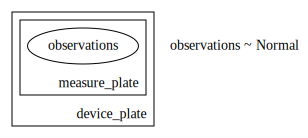

In [6]:
# iii) Illustrate the model
graphical_model = pyro.render_model(model = model, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)

graphical_model


### What is a **Guide** in Pyro?

In Variational Inference we approximate the (usually intractable) posterior $p(z \mid x;\,\theta)$ with a **variational family** $q_\phi(z)$ whose parameters $\phi$ are optimised to make $q_\phi$ as close as possible to the true posterior (typically by minimising the ELBO).

**Key facts for this notebook**

* Our model has **no latent variables** $z$.  
  ⇒ The true posterior is *trivial* and does not need approximation.
* Therefore the guide can be an **empty stub** — it returns nothing and defines no parameters.
* Pyro still expects a callable `guide(*model_args, **model_kwargs)` with the **same signature** as the model, so we provide:


In [7]:
# ii) Build the guide
def guide(input_vars = T_true, observations = None):
    pass


## 3. Perform inference

We use `pyro.infer.SVI` with the standard ELBO loss.  
Because there are no parameters to optimize, the training loop will show **no improvement** — but the loss still measures **negative log-likelihood**.

---

### 🔬 ELBO in This Case

Since there are no latent variables or learned parameters, the ELBO simplifies to:

$$
\text{ELBO} = -\log p(x) = -\sum_i \log \mathcal{N}(x_i \mid T_{\text{true}}, \sigma)
$$

This allows us to directly interpret the loss as a measure of **model fit**.


In [8]:
"""
    3. Perform inference
"""

# i) Set up inference
# This requires us specifying an optimizer, a loss function, and the inference
# machinery. 
adam = pyro.optim.Adam({"lr": 0.1})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

# ii) Perform svi
# Normally, compute gradients and backprop. But nothing really happens for this
# trivial model and the loss stays constant.
data = (T_true, T_meas)
loss_sequence = []
for step in range(100):
    loss = svi.step(*data)
    loss_sequence.append(loss)
    if step %10 == 0:
        print(f'epoch: {step} ; loss : {loss}')
   

epoch: 0 ; loss : 7283.184806205677
epoch: 10 ; loss : 7283.184806205677
epoch: 20 ; loss : 7283.184806205677
epoch: 30 ; loss : 7283.184806205677
epoch: 40 ; loss : 7283.184806205677
epoch: 50 ; loss : 7283.184806205677
epoch: 60 ; loss : 7283.184806205677
epoch: 70 ; loss : 7283.184806205677
epoch: 80 ; loss : 7283.184806205677
epoch: 90 ; loss : 7283.184806205677


### 🧪 Manually Computing the Log Evidence

We compute the same quantity as the ELBO manually using `obs_dist.log_prob(...)`.  
This verifies that our theoretical expectation matches Pyro’s internal computations.


In [9]:
# We will also compute the log evidence by hand to show that the ELBO has the 
# very specific meaning of being the - log evidence in this example.
obs_dist = pyro.distributions.Normal(loc = T_true, scale = sigma_T_meas)
log_prob = torch.sum(obs_dist.log_prob(T_meas))

# We can also sample our model to produce some new data and evaluate how good
# our  model is also visually (not only computationally via the ELBO). 
model_data = model(T_true)


## 4. Interpretations and illustrations

We compare:

- The **actual measurements** from the CSV
- The **samples generated by our trivial model**

This gives us a visual sense of what it means for a model to “fit” or not.

Even though the model produces output, we’ll clearly see that it **fails to capture sensor-specific behavior**, outliers, and nonlinearities.

---

📉 The ELBO loss also gives us a **baseline score** that we can beat in later notebooks.


 ELBO loss : 7283.184806205677 ,
 - log prob of data : 7283.184806205677


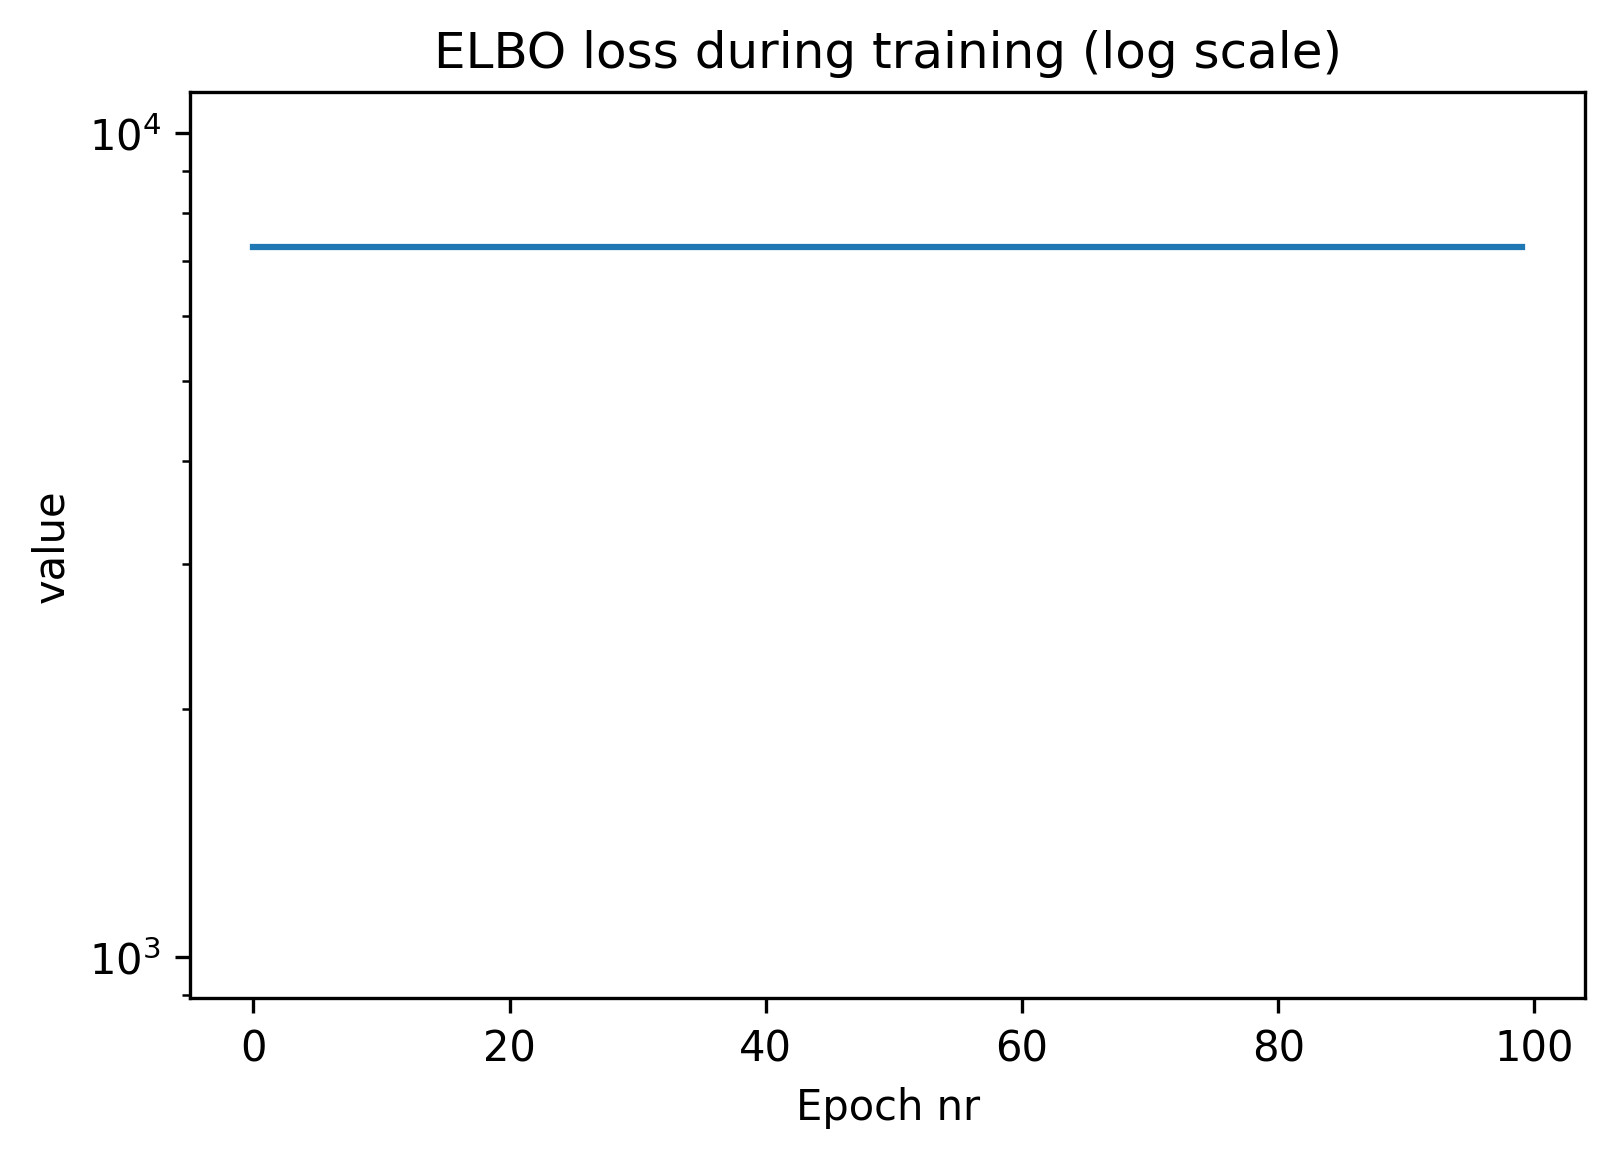

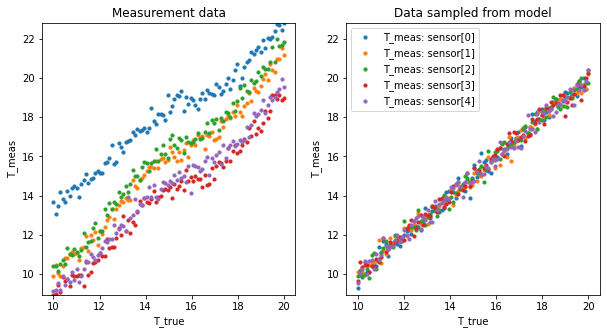

In [10]:
"""
    4. Interpretations and illustrations
"""

# i) Plot and print ELBO loss
# The ELBO is simply the - log evidence = - log probability of the data for
# this simple model.
print(' ELBO loss : {} ,\n - log prob of data : {}'.format(loss, -log_prob))

# The training does not adjust the model since the model has no adjustable parameters
plt.figure(1, dpi = 300)
plt.plot(loss_sequence)
plt.yscale("log")
plt.title('ELBO loss during training (log scale)')
plt.xlabel('Epoch nr')
plt.ylabel('value')


# ii) Compare model output and data
# Create the figure and 1x5 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
# Global y-axis limits
y_min = T_meas.min()
y_max = T_meas.max()

# First plot: measurement data
for i in range(n_device):
    axes[0].scatter(T_true[i,:], T_meas[i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0].set_title("Measurement data")
axes[0].set_xlabel("T_true")
axes[0].set_ylabel("T_meas")
axes[0].set_ylim(y_min, y_max)

# Second plot: data produced by model
for i in range(n_device):
    axes[1].scatter(T_true[i,:], model_data[i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1].set_title("Data sampled from model")
axes[1].set_xlabel("T_true")
axes[1].set_ylabel("T_meas")
axes[1].set_ylim(y_min, y_max)
axes[1].legend()
    

---

## 🧾 Summary

- Built a **parameter-free** Gaussian error model  
- Ran SVI to obtain the ELBO, which equals $-\log p(x)$ here  
- Verified Pyro’s ELBO against a manual computation  
- Visualised that the model fails to capture device-specific biases or nonlinearities  

📌 Next → `pyro_cc_2_model_1`: introduce **trainable offset and scale parameters** so the model can learn from the data.
